# Dataset 4 - Boston

## Import Libraries 

In [1]:
import warnings
import sys
sys.path.insert(0, '../src')
warnings.filterwarnings('ignore')

In [2]:
import train_test
import ABC_train_test
import bostonDataset
import baselineModels
import network
import statsModel
import performanceMetrics
import dataset
import sanityChecks
import torch 
import matplotlib.pyplot as plt 
import seaborn as sns 
from torch.utils.data import random_split 
from sklearn.model_selection import train_test_split

## Parameters

General Parameters 

1. Number of Samples
2. Number of features 

ABC-Generator parameters are as mentioned below: 
1. mean : 1 ($\beta \sim N(\beta^{*},\sigma)$ where $\beta^{*}$ are coefficients of statistical model) or 1 ($\beta \sim N(0,\sigma)$
2. std : $\sigma = 1, 0.1 , 0.01$ (standard deviation)

In [3]:
n_features = 13
n_samples= 506
n_target = 1 
 
#ABC Generator Parameters
mean = 1 
variance = 0.01

#Hyper-parameters 
n_epochs = 100

In [4]:
# Parameters
mean = 1
variance = 0.1
n_epochs = 5000


## Dataset

In [5]:
X,Y = bostonDataset.boston_data()

        X1    X2    X3   X4     X5     X6    X7      X8   X9    X10   X11  \
0  0.00632  18.0  2.31  0.0  0.538  6.575  65.2  4.0900  1.0  296.0  15.3   
1  0.02731   0.0  7.07  0.0  0.469  6.421  78.9  4.9671  2.0  242.0  17.8   
2  0.02729   0.0  7.07  0.0  0.469  7.185  61.1  4.9671  2.0  242.0  17.8   
3  0.03237   0.0  2.18  0.0  0.458  6.998  45.8  6.0622  3.0  222.0  18.7   
4  0.06905   0.0  2.18  0.0  0.458  7.147  54.2  6.0622  3.0  222.0  18.7   

      X12   X13     Y  
0  396.90  4.98  24.0  
1  396.90  9.14  21.6  
2  392.83  4.03  34.7  
3  394.63  2.94  33.4  
4  396.90  5.33  36.2  


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

## Stats Model

No handles with labels found to put in legend.


                                 OLS Regression Results                                
Dep. Variable:                      Y   R-squared (uncentered):                   0.729
Model:                            OLS   Adj. R-squared (uncentered):              0.720
Method:                 Least Squares   F-statistic:                              80.74
Date:                Fri, 26 Nov 2021   Prob (F-statistic):                   5.08e-102
Time:                        19:39:20   Log-Likelihood:                         -316.56
No. Observations:                 404   AIC:                                      659.1
Df Residuals:                     391   BIC:                                      711.1
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

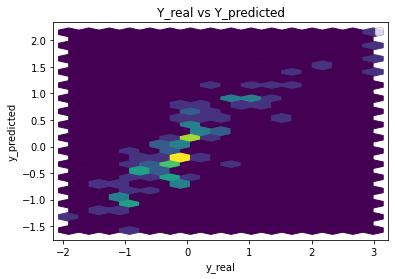

Performance Metrics
Mean Squared Error: 0.1848937729795544
Mean Absolute Error: 0.3167218338017366
Manhattan distance: 32.305627047777136
Euclidean distance: 4.342713995177964


In [7]:
[coeff,y_pred] = statsModel.statsModel(X,Y)

## Random Forest

In [8]:
mse_rf = baselineModels.randomForest(X_train,y_train,X_test,y_test)

Mean Squared error 0.17170188335095354


## Catboost

In [9]:
mse_cb = baselineModels.catboost(X_train,y_train,X_test,y_test)

Learning rate set to 0.03548
0:	learn: 0.9648797	total: 157ms	remaining: 2m 37s
1:	learn: 0.9481659	total: 161ms	remaining: 1m 20s
2:	learn: 0.9288886	total: 166ms	remaining: 55s
3:	learn: 0.9098407	total: 170ms	remaining: 42.2s
4:	learn: 0.8918687	total: 173ms	remaining: 34.5s
5:	learn: 0.8747882	total: 178ms	remaining: 29.4s
6:	learn: 0.8576230	total: 181ms	remaining: 25.7s


7:	learn: 0.8413112	total: 186ms	remaining: 23s
8:	learn: 0.8261240	total: 189ms	remaining: 20.8s
9:	learn: 0.8106487	total: 193ms	remaining: 19.2s
10:	learn: 0.7964434	total: 198ms	remaining: 17.8s
11:	learn: 0.7826262	total: 201ms	remaining: 16.6s
12:	learn: 0.7682909	total: 206ms	remaining: 15.6s
13:	learn: 0.7538099	total: 210ms	remaining: 14.8s
14:	learn: 0.7415181	total: 214ms	remaining: 14s
15:	learn: 0.7274224	total: 219ms	remaining: 13.4s
16:	learn: 0.7158722	total: 223ms	remaining: 12.9s
17:	learn: 0.7036892	total: 227ms	remaining: 12.4s
18:	learn: 0.6912344	total: 231ms	remaining: 11.9s
19:	learn: 0.6795093	total: 235ms	remaining: 11.5s
20:	learn: 0.6690139	total: 238ms	remaining: 11.1s
21:	learn: 0.6589059	total: 243ms	remaining: 10.8s
22:	learn: 0.6474134	total: 246ms	remaining: 10.4s
23:	learn: 0.6384510	total: 250ms	remaining: 10.2s
24:	learn: 0.6284961	total: 253ms	remaining: 9.87s
25:	learn: 0.6193195	total: 257ms	remaining: 9.63s
26:	learn: 0.6092869	total: 260ms	rema

52:	learn: 0.4379781	total: 357ms	remaining: 6.38s
53:	learn: 0.4346696	total: 360ms	remaining: 6.31s
54:	learn: 0.4301875	total: 363ms	remaining: 6.24s
55:	learn: 0.4267359	total: 367ms	remaining: 6.18s
56:	learn: 0.4236828	total: 370ms	remaining: 6.12s
57:	learn: 0.4196661	total: 374ms	remaining: 6.07s
58:	learn: 0.4165562	total: 377ms	remaining: 6.01s
59:	learn: 0.4126688	total: 381ms	remaining: 5.96s
60:	learn: 0.4084337	total: 384ms	remaining: 5.91s
61:	learn: 0.4040724	total: 388ms	remaining: 5.87s
62:	learn: 0.4018409	total: 391ms	remaining: 5.82s
63:	learn: 0.3989285	total: 395ms	remaining: 5.78s
64:	learn: 0.3960903	total: 399ms	remaining: 5.73s
65:	learn: 0.3916675	total: 403ms	remaining: 5.7s
66:	learn: 0.3880885	total: 406ms	remaining: 5.65s
67:	learn: 0.3850018	total: 410ms	remaining: 5.62s
68:	learn: 0.3819902	total: 413ms	remaining: 5.58s
69:	learn: 0.3795313	total: 417ms	remaining: 5.54s
70:	learn: 0.3758420	total: 420ms	remaining: 5.5s
71:	learn: 0.3717051	total: 424ms

100:	learn: 0.3087012	total: 527ms	remaining: 4.7s
101:	learn: 0.3068995	total: 531ms	remaining: 4.67s
102:	learn: 0.3054747	total: 534ms	remaining: 4.65s
103:	learn: 0.3040422	total: 538ms	remaining: 4.63s
104:	learn: 0.3028705	total: 541ms	remaining: 4.61s
105:	learn: 0.3014416	total: 545ms	remaining: 4.6s
106:	learn: 0.2995639	total: 548ms	remaining: 4.58s
107:	learn: 0.2975087	total: 552ms	remaining: 4.56s
108:	learn: 0.2959507	total: 555ms	remaining: 4.54s
109:	learn: 0.2947021	total: 559ms	remaining: 4.52s
110:	learn: 0.2932648	total: 562ms	remaining: 4.5s
111:	learn: 0.2922907	total: 566ms	remaining: 4.48s
112:	learn: 0.2905139	total: 569ms	remaining: 4.47s
113:	learn: 0.2893682	total: 572ms	remaining: 4.45s
114:	learn: 0.2875574	total: 576ms	remaining: 4.43s
115:	learn: 0.2856935	total: 579ms	remaining: 4.42s
116:	learn: 0.2843315	total: 583ms	remaining: 4.4s
117:	learn: 0.2826824	total: 586ms	remaining: 4.38s
118:	learn: 0.2815262	total: 590ms	remaining: 4.37s
119:	learn: 0.28

145:	learn: 0.2517512	total: 700ms	remaining: 4.09s
146:	learn: 0.2510032	total: 704ms	remaining: 4.08s
147:	learn: 0.2502355	total: 708ms	remaining: 4.08s
148:	learn: 0.2491390	total: 712ms	remaining: 4.07s
149:	learn: 0.2485139	total: 716ms	remaining: 4.06s
150:	learn: 0.2475431	total: 720ms	remaining: 4.05s
151:	learn: 0.2467471	total: 724ms	remaining: 4.04s
152:	learn: 0.2460382	total: 728ms	remaining: 4.03s
153:	learn: 0.2452381	total: 733ms	remaining: 4.03s
154:	learn: 0.2446035	total: 737ms	remaining: 4.02s
155:	learn: 0.2437197	total: 741ms	remaining: 4.01s
156:	learn: 0.2425518	total: 746ms	remaining: 4s
157:	learn: 0.2418548	total: 750ms	remaining: 4s
158:	learn: 0.2408159	total: 754ms	remaining: 3.99s
159:	learn: 0.2397245	total: 758ms	remaining: 3.98s
160:	learn: 0.2387785	total: 763ms	remaining: 3.97s
161:	learn: 0.2381177	total: 766ms	remaining: 3.96s
162:	learn: 0.2373584	total: 770ms	remaining: 3.95s
163:	learn: 0.2366714	total: 773ms	remaining: 3.94s
164:	learn: 0.2360

189:	learn: 0.2177051	total: 868ms	remaining: 3.7s
190:	learn: 0.2169220	total: 872ms	remaining: 3.69s
191:	learn: 0.2162033	total: 876ms	remaining: 3.69s
192:	learn: 0.2154279	total: 880ms	remaining: 3.68s
193:	learn: 0.2148952	total: 884ms	remaining: 3.67s
194:	learn: 0.2142721	total: 887ms	remaining: 3.66s
195:	learn: 0.2136015	total: 891ms	remaining: 3.65s
196:	learn: 0.2133089	total: 894ms	remaining: 3.64s
197:	learn: 0.2127569	total: 898ms	remaining: 3.64s
198:	learn: 0.2121798	total: 902ms	remaining: 3.63s
199:	learn: 0.2113538	total: 906ms	remaining: 3.62s
200:	learn: 0.2104523	total: 910ms	remaining: 3.62s
201:	learn: 0.2099475	total: 914ms	remaining: 3.61s
202:	learn: 0.2094544	total: 918ms	remaining: 3.6s
203:	learn: 0.2085619	total: 922ms	remaining: 3.6s
204:	learn: 0.2079364	total: 926ms	remaining: 3.59s
205:	learn: 0.2073155	total: 930ms	remaining: 3.58s
206:	learn: 0.2066191	total: 934ms	remaining: 3.58s
207:	learn: 0.2062420	total: 937ms	remaining: 3.57s
208:	learn: 0.2

234:	learn: 0.1910150	total: 1.03s	remaining: 3.37s
235:	learn: 0.1907935	total: 1.04s	remaining: 3.36s
236:	learn: 0.1903554	total: 1.04s	remaining: 3.35s
237:	learn: 0.1901541	total: 1.04s	remaining: 3.35s
238:	learn: 0.1897133	total: 1.05s	remaining: 3.34s
239:	learn: 0.1891388	total: 1.05s	remaining: 3.33s
240:	learn: 0.1887930	total: 1.05s	remaining: 3.33s
241:	learn: 0.1885424	total: 1.06s	remaining: 3.32s
242:	learn: 0.1879101	total: 1.06s	remaining: 3.31s
243:	learn: 0.1872794	total: 1.07s	remaining: 3.3s
244:	learn: 0.1867224	total: 1.07s	remaining: 3.3s
245:	learn: 0.1861548	total: 1.07s	remaining: 3.29s
246:	learn: 0.1856145	total: 1.08s	remaining: 3.28s
247:	learn: 0.1850373	total: 1.08s	remaining: 3.27s
248:	learn: 0.1847112	total: 1.08s	remaining: 3.27s
249:	learn: 0.1842995	total: 1.09s	remaining: 3.26s
250:	learn: 0.1837993	total: 1.09s	remaining: 3.25s
251:	learn: 0.1832385	total: 1.09s	remaining: 3.25s
252:	learn: 0.1826935	total: 1.1s	remaining: 3.24s
253:	learn: 0.1

282:	learn: 0.1687388	total: 1.2s	remaining: 3.04s
283:	learn: 0.1682553	total: 1.2s	remaining: 3.04s
284:	learn: 0.1677014	total: 1.21s	remaining: 3.03s
285:	learn: 0.1675810	total: 1.21s	remaining: 3.02s
286:	learn: 0.1670880	total: 1.21s	remaining: 3.02s
287:	learn: 0.1667415	total: 1.22s	remaining: 3.01s
288:	learn: 0.1663009	total: 1.22s	remaining: 3s
289:	learn: 0.1659079	total: 1.22s	remaining: 3s
290:	learn: 0.1655510	total: 1.23s	remaining: 2.99s
291:	learn: 0.1650258	total: 1.23s	remaining: 2.99s
292:	learn: 0.1648671	total: 1.24s	remaining: 2.98s
293:	learn: 0.1644561	total: 1.24s	remaining: 2.98s
294:	learn: 0.1640001	total: 1.24s	remaining: 2.97s
295:	learn: 0.1636902	total: 1.25s	remaining: 2.96s
296:	learn: 0.1634168	total: 1.25s	remaining: 2.96s
297:	learn: 0.1633070	total: 1.25s	remaining: 2.95s
298:	learn: 0.1627887	total: 1.26s	remaining: 2.94s
299:	learn: 0.1622713	total: 1.26s	remaining: 2.94s
300:	learn: 0.1619341	total: 1.26s	remaining: 2.93s
301:	learn: 0.161410

330:	learn: 0.1513904	total: 1.37s	remaining: 2.76s
331:	learn: 0.1509669	total: 1.37s	remaining: 2.76s
332:	learn: 0.1506507	total: 1.37s	remaining: 2.75s
333:	learn: 0.1505622	total: 1.38s	remaining: 2.75s
334:	learn: 0.1500879	total: 1.38s	remaining: 2.74s
335:	learn: 0.1497546	total: 1.39s	remaining: 2.74s
336:	learn: 0.1493561	total: 1.39s	remaining: 2.73s
337:	learn: 0.1491008	total: 1.39s	remaining: 2.73s
338:	learn: 0.1489475	total: 1.4s	remaining: 2.72s
339:	learn: 0.1486783	total: 1.4s	remaining: 2.72s
340:	learn: 0.1486258	total: 1.41s	remaining: 2.71s
341:	learn: 0.1482234	total: 1.41s	remaining: 2.71s
342:	learn: 0.1478935	total: 1.41s	remaining: 2.71s
343:	learn: 0.1475550	total: 1.42s	remaining: 2.7s
344:	learn: 0.1472101	total: 1.42s	remaining: 2.7s
345:	learn: 0.1468591	total: 1.42s	remaining: 2.69s
346:	learn: 0.1465083	total: 1.43s	remaining: 2.69s
347:	learn: 0.1461711	total: 1.43s	remaining: 2.68s
348:	learn: 0.1459581	total: 1.44s	remaining: 2.68s
349:	learn: 0.14

375:	learn: 0.1386126	total: 1.53s	remaining: 2.55s
376:	learn: 0.1385663	total: 1.54s	remaining: 2.54s
377:	learn: 0.1385204	total: 1.54s	remaining: 2.54s
378:	learn: 0.1384758	total: 1.54s	remaining: 2.53s
379:	learn: 0.1380619	total: 1.55s	remaining: 2.53s
380:	learn: 0.1376593	total: 1.55s	remaining: 2.52s
381:	learn: 0.1373592	total: 1.56s	remaining: 2.52s
382:	learn: 0.1372399	total: 1.56s	remaining: 2.51s
383:	learn: 0.1368024	total: 1.56s	remaining: 2.51s
384:	learn: 0.1364854	total: 1.57s	remaining: 2.5s
385:	learn: 0.1363288	total: 1.57s	remaining: 2.5s
386:	learn: 0.1360851	total: 1.57s	remaining: 2.49s
387:	learn: 0.1359597	total: 1.58s	remaining: 2.49s
388:	learn: 0.1357054	total: 1.58s	remaining: 2.48s
389:	learn: 0.1356657	total: 1.58s	remaining: 2.48s
390:	learn: 0.1353836	total: 1.59s	remaining: 2.47s
391:	learn: 0.1352153	total: 1.59s	remaining: 2.47s
392:	learn: 0.1351813	total: 1.59s	remaining: 2.46s
393:	learn: 0.1351203	total: 1.6s	remaining: 2.46s
394:	learn: 0.1

423:	learn: 0.1279434	total: 1.7s	remaining: 2.32s
424:	learn: 0.1277418	total: 1.71s	remaining: 2.31s
425:	learn: 0.1272723	total: 1.71s	remaining: 2.31s
426:	learn: 0.1269628	total: 1.71s	remaining: 2.3s
427:	learn: 0.1266383	total: 1.72s	remaining: 2.3s
428:	learn: 0.1266025	total: 1.72s	remaining: 2.29s
429:	learn: 0.1265720	total: 1.73s	remaining: 2.29s
430:	learn: 0.1261570	total: 1.73s	remaining: 2.28s
431:	learn: 0.1261223	total: 1.73s	remaining: 2.28s
432:	learn: 0.1257369	total: 1.74s	remaining: 2.27s
433:	learn: 0.1254671	total: 1.74s	remaining: 2.27s
434:	learn: 0.1251315	total: 1.74s	remaining: 2.26s
435:	learn: 0.1248442	total: 1.75s	remaining: 2.26s
436:	learn: 0.1246915	total: 1.75s	remaining: 2.25s
437:	learn: 0.1244238	total: 1.75s	remaining: 2.25s
438:	learn: 0.1241874	total: 1.76s	remaining: 2.25s
439:	learn: 0.1239785	total: 1.76s	remaining: 2.24s
440:	learn: 0.1238299	total: 1.76s	remaining: 2.23s
441:	learn: 0.1235801	total: 1.77s	remaining: 2.23s
442:	learn: 0.1

471:	learn: 0.1183947	total: 1.87s	remaining: 2.09s
472:	learn: 0.1183727	total: 1.87s	remaining: 2.08s
473:	learn: 0.1180801	total: 1.88s	remaining: 2.08s
474:	learn: 0.1180540	total: 1.88s	remaining: 2.08s
475:	learn: 0.1180357	total: 1.88s	remaining: 2.07s
476:	learn: 0.1177876	total: 1.89s	remaining: 2.07s
477:	learn: 0.1174726	total: 1.89s	remaining: 2.06s
478:	learn: 0.1171689	total: 1.89s	remaining: 2.06s
479:	learn: 0.1168722	total: 1.9s	remaining: 2.06s
480:	learn: 0.1167280	total: 1.9s	remaining: 2.05s
481:	learn: 0.1164815	total: 1.9s	remaining: 2.05s
482:	learn: 0.1161452	total: 1.91s	remaining: 2.04s
483:	learn: 0.1158340	total: 1.91s	remaining: 2.04s
484:	learn: 0.1154626	total: 1.92s	remaining: 2.03s
485:	learn: 0.1151922	total: 1.92s	remaining: 2.03s
486:	learn: 0.1150902	total: 1.92s	remaining: 2.02s
487:	learn: 0.1148511	total: 1.93s	remaining: 2.02s
488:	learn: 0.1148277	total: 1.93s	remaining: 2.02s
489:	learn: 0.1144933	total: 1.93s	remaining: 2.01s
490:	learn: 0.1

516:	learn: 0.1095678	total: 2.04s	remaining: 1.91s
517:	learn: 0.1095513	total: 2.04s	remaining: 1.9s
518:	learn: 0.1093935	total: 2.05s	remaining: 1.9s
519:	learn: 0.1092186	total: 2.05s	remaining: 1.89s
520:	learn: 0.1090078	total: 2.06s	remaining: 1.89s
521:	learn: 0.1089172	total: 2.06s	remaining: 1.89s
522:	learn: 0.1086715	total: 2.06s	remaining: 1.88s
523:	learn: 0.1084373	total: 2.07s	remaining: 1.88s
524:	learn: 0.1083272	total: 2.07s	remaining: 1.87s
525:	learn: 0.1082484	total: 2.08s	remaining: 1.87s
526:	learn: 0.1080310	total: 2.08s	remaining: 1.86s
527:	learn: 0.1079978	total: 2.08s	remaining: 1.86s
528:	learn: 0.1076020	total: 2.08s	remaining: 1.86s
529:	learn: 0.1073521	total: 2.09s	remaining: 1.85s
530:	learn: 0.1071159	total: 2.09s	remaining: 1.85s
531:	learn: 0.1069417	total: 2.1s	remaining: 1.84s
532:	learn: 0.1069143	total: 2.1s	remaining: 1.84s
533:	learn: 0.1067241	total: 2.1s	remaining: 1.83s
534:	learn: 0.1064819	total: 2.11s	remaining: 1.83s
535:	learn: 0.106

562:	learn: 0.1015557	total: 2.21s	remaining: 1.71s
563:	learn: 0.1013200	total: 2.21s	remaining: 1.71s
564:	learn: 0.1010783	total: 2.21s	remaining: 1.7s
565:	learn: 0.1009611	total: 2.22s	remaining: 1.7s
566:	learn: 0.1007237	total: 2.22s	remaining: 1.7s
567:	learn: 0.1006891	total: 2.22s	remaining: 1.69s
568:	learn: 0.1005270	total: 2.23s	remaining: 1.69s
569:	learn: 0.1003936	total: 2.23s	remaining: 1.68s
570:	learn: 0.1002973	total: 2.23s	remaining: 1.68s
571:	learn: 0.1001757	total: 2.24s	remaining: 1.67s
572:	learn: 0.0999162	total: 2.24s	remaining: 1.67s
573:	learn: 0.0996957	total: 2.24s	remaining: 1.67s
574:	learn: 0.0995321	total: 2.25s	remaining: 1.66s
575:	learn: 0.0992990	total: 2.25s	remaining: 1.66s
576:	learn: 0.0990970	total: 2.25s	remaining: 1.65s
577:	learn: 0.0989797	total: 2.26s	remaining: 1.65s
578:	learn: 0.0987161	total: 2.26s	remaining: 1.64s
579:	learn: 0.0985065	total: 2.26s	remaining: 1.64s
580:	learn: 0.0983092	total: 2.27s	remaining: 1.64s
581:	learn: 0.0

610:	learn: 0.0935930	total: 2.37s	remaining: 1.51s
611:	learn: 0.0934916	total: 2.38s	remaining: 1.51s
612:	learn: 0.0934129	total: 2.38s	remaining: 1.5s
613:	learn: 0.0932545	total: 2.38s	remaining: 1.5s
614:	learn: 0.0929940	total: 2.39s	remaining: 1.49s
615:	learn: 0.0929064	total: 2.39s	remaining: 1.49s
616:	learn: 0.0927860	total: 2.39s	remaining: 1.49s
617:	learn: 0.0925844	total: 2.4s	remaining: 1.48s
618:	learn: 0.0925245	total: 2.4s	remaining: 1.48s
619:	learn: 0.0924595	total: 2.4s	remaining: 1.47s
620:	learn: 0.0923697	total: 2.41s	remaining: 1.47s
621:	learn: 0.0922285	total: 2.41s	remaining: 1.47s
622:	learn: 0.0921819	total: 2.41s	remaining: 1.46s
623:	learn: 0.0919927	total: 2.42s	remaining: 1.46s
624:	learn: 0.0917502	total: 2.42s	remaining: 1.45s
625:	learn: 0.0916867	total: 2.42s	remaining: 1.45s
626:	learn: 0.0915514	total: 2.43s	remaining: 1.44s
627:	learn: 0.0912277	total: 2.43s	remaining: 1.44s
628:	learn: 0.0911041	total: 2.43s	remaining: 1.44s
629:	learn: 0.091

659:	learn: 0.0870003	total: 2.54s	remaining: 1.31s
660:	learn: 0.0868896	total: 2.54s	remaining: 1.3s
661:	learn: 0.0867342	total: 2.55s	remaining: 1.3s
662:	learn: 0.0865208	total: 2.55s	remaining: 1.3s
663:	learn: 0.0863754	total: 2.56s	remaining: 1.29s
664:	learn: 0.0862782	total: 2.56s	remaining: 1.29s
665:	learn: 0.0862316	total: 2.56s	remaining: 1.28s
666:	learn: 0.0859861	total: 2.57s	remaining: 1.28s
667:	learn: 0.0858102	total: 2.57s	remaining: 1.28s
668:	learn: 0.0856837	total: 2.57s	remaining: 1.27s
669:	learn: 0.0855959	total: 2.58s	remaining: 1.27s
670:	learn: 0.0855229	total: 2.58s	remaining: 1.26s
671:	learn: 0.0853048	total: 2.58s	remaining: 1.26s
672:	learn: 0.0852342	total: 2.59s	remaining: 1.26s
673:	learn: 0.0851832	total: 2.59s	remaining: 1.25s
674:	learn: 0.0849954	total: 2.59s	remaining: 1.25s
675:	learn: 0.0849354	total: 2.6s	remaining: 1.25s
676:	learn: 0.0848588	total: 2.6s	remaining: 1.24s
677:	learn: 0.0847538	total: 2.6s	remaining: 1.24s
678:	learn: 0.0845

706:	learn: 0.0814883	total: 2.7s	remaining: 1.12s
707:	learn: 0.0814133	total: 2.71s	remaining: 1.12s
708:	learn: 0.0812054	total: 2.71s	remaining: 1.11s
709:	learn: 0.0811526	total: 2.71s	remaining: 1.11s
710:	learn: 0.0811411	total: 2.72s	remaining: 1.1s
711:	learn: 0.0809990	total: 2.72s	remaining: 1.1s
712:	learn: 0.0809917	total: 2.72s	remaining: 1.1s
713:	learn: 0.0808005	total: 2.73s	remaining: 1.09s
714:	learn: 0.0807431	total: 2.73s	remaining: 1.09s
715:	learn: 0.0806429	total: 2.73s	remaining: 1.08s
716:	learn: 0.0805194	total: 2.74s	remaining: 1.08s
717:	learn: 0.0803870	total: 2.74s	remaining: 1.08s
718:	learn: 0.0802290	total: 2.74s	remaining: 1.07s
719:	learn: 0.0800926	total: 2.75s	remaining: 1.07s
720:	learn: 0.0799363	total: 2.75s	remaining: 1.06s
721:	learn: 0.0797720	total: 2.75s	remaining: 1.06s
722:	learn: 0.0797137	total: 2.76s	remaining: 1.06s
723:	learn: 0.0795450	total: 2.76s	remaining: 1.05s
724:	learn: 0.0793736	total: 2.77s	remaining: 1.05s
725:	learn: 0.07

755:	learn: 0.0755422	total: 2.87s	remaining: 927ms
756:	learn: 0.0754532	total: 2.88s	remaining: 923ms
757:	learn: 0.0754320	total: 2.88s	remaining: 919ms
758:	learn: 0.0753485	total: 2.88s	remaining: 915ms
759:	learn: 0.0751644	total: 2.88s	remaining: 911ms
760:	learn: 0.0749849	total: 2.89s	remaining: 908ms
761:	learn: 0.0748431	total: 2.89s	remaining: 904ms
762:	learn: 0.0747468	total: 2.9s	remaining: 900ms
763:	learn: 0.0747376	total: 2.9s	remaining: 896ms
764:	learn: 0.0746474	total: 2.9s	remaining: 892ms
765:	learn: 0.0745025	total: 2.91s	remaining: 888ms
766:	learn: 0.0744090	total: 2.91s	remaining: 884ms
767:	learn: 0.0744003	total: 2.91s	remaining: 880ms
768:	learn: 0.0742478	total: 2.92s	remaining: 876ms
769:	learn: 0.0742132	total: 2.92s	remaining: 872ms
770:	learn: 0.0741573	total: 2.92s	remaining: 868ms
771:	learn: 0.0740430	total: 2.93s	remaining: 864ms
772:	learn: 0.0738563	total: 2.93s	remaining: 861ms
773:	learn: 0.0737416	total: 2.93s	remaining: 857ms
774:	learn: 0.0

801:	learn: 0.0708877	total: 3.04s	remaining: 750ms
802:	learn: 0.0707381	total: 3.04s	remaining: 746ms
803:	learn: 0.0706189	total: 3.05s	remaining: 743ms
804:	learn: 0.0704787	total: 3.05s	remaining: 739ms
805:	learn: 0.0704011	total: 3.05s	remaining: 735ms
806:	learn: 0.0703025	total: 3.06s	remaining: 731ms
807:	learn: 0.0702578	total: 3.06s	remaining: 727ms
808:	learn: 0.0701844	total: 3.06s	remaining: 724ms
809:	learn: 0.0700832	total: 3.07s	remaining: 720ms
810:	learn: 0.0699595	total: 3.07s	remaining: 716ms
811:	learn: 0.0698282	total: 3.08s	remaining: 712ms
812:	learn: 0.0698176	total: 3.08s	remaining: 708ms
813:	learn: 0.0696949	total: 3.08s	remaining: 705ms
814:	learn: 0.0695550	total: 3.09s	remaining: 701ms
815:	learn: 0.0695181	total: 3.09s	remaining: 697ms
816:	learn: 0.0694418	total: 3.09s	remaining: 693ms
817:	learn: 0.0693719	total: 3.1s	remaining: 689ms
818:	learn: 0.0692841	total: 3.1s	remaining: 685ms
819:	learn: 0.0692120	total: 3.1s	remaining: 681ms
820:	learn: 0.0

850:	learn: 0.0660984	total: 3.21s	remaining: 562ms
851:	learn: 0.0659779	total: 3.21s	remaining: 558ms
852:	learn: 0.0659091	total: 3.21s	remaining: 554ms
853:	learn: 0.0657697	total: 3.22s	remaining: 550ms
854:	learn: 0.0657542	total: 3.22s	remaining: 546ms
855:	learn: 0.0656768	total: 3.22s	remaining: 542ms
856:	learn: 0.0656599	total: 3.22s	remaining: 538ms
857:	learn: 0.0655859	total: 3.23s	remaining: 534ms
858:	learn: 0.0655108	total: 3.23s	remaining: 530ms
859:	learn: 0.0654617	total: 3.23s	remaining: 526ms
860:	learn: 0.0654484	total: 3.23s	remaining: 522ms
861:	learn: 0.0654050	total: 3.24s	remaining: 518ms
862:	learn: 0.0653573	total: 3.24s	remaining: 514ms
863:	learn: 0.0652257	total: 3.24s	remaining: 510ms
864:	learn: 0.0651371	total: 3.24s	remaining: 506ms
865:	learn: 0.0650583	total: 3.25s	remaining: 503ms
866:	learn: 0.0649104	total: 3.25s	remaining: 499ms
867:	learn: 0.0648888	total: 3.25s	remaining: 495ms
868:	learn: 0.0647368	total: 3.25s	remaining: 491ms
869:	learn: 

912:	learn: 0.0607551	total: 3.38s	remaining: 322ms
913:	learn: 0.0606514	total: 3.38s	remaining: 318ms
914:	learn: 0.0606106	total: 3.38s	remaining: 314ms
915:	learn: 0.0605273	total: 3.39s	remaining: 311ms
916:	learn: 0.0604704	total: 3.39s	remaining: 307ms
917:	learn: 0.0603919	total: 3.39s	remaining: 303ms
918:	learn: 0.0603309	total: 3.4s	remaining: 299ms
919:	learn: 0.0603017	total: 3.4s	remaining: 296ms
920:	learn: 0.0601697	total: 3.4s	remaining: 292ms
921:	learn: 0.0600109	total: 3.4s	remaining: 288ms
922:	learn: 0.0599237	total: 3.41s	remaining: 284ms
923:	learn: 0.0597878	total: 3.41s	remaining: 281ms
924:	learn: 0.0597627	total: 3.41s	remaining: 277ms
925:	learn: 0.0597236	total: 3.42s	remaining: 273ms
926:	learn: 0.0595873	total: 3.42s	remaining: 269ms
927:	learn: 0.0594788	total: 3.42s	remaining: 266ms
928:	learn: 0.0593688	total: 3.42s	remaining: 262ms
929:	learn: 0.0592813	total: 3.43s	remaining: 258ms
930:	learn: 0.0592344	total: 3.43s	remaining: 254ms
931:	learn: 0.05

976:	learn: 0.0559246	total: 3.55s	remaining: 83.7ms
977:	learn: 0.0558882	total: 3.56s	remaining: 80ms
978:	learn: 0.0558541	total: 3.56s	remaining: 76.3ms
979:	learn: 0.0557781	total: 3.56s	remaining: 72.7ms
980:	learn: 0.0557286	total: 3.56s	remaining: 69ms
981:	learn: 0.0556959	total: 3.57s	remaining: 65.4ms
982:	learn: 0.0556775	total: 3.57s	remaining: 61.7ms
983:	learn: 0.0556643	total: 3.57s	remaining: 58.1ms
984:	learn: 0.0555872	total: 3.58s	remaining: 54.4ms
985:	learn: 0.0555136	total: 3.58s	remaining: 50.8ms
986:	learn: 0.0554823	total: 3.58s	remaining: 47.2ms
987:	learn: 0.0553903	total: 3.58s	remaining: 43.5ms
988:	learn: 0.0553501	total: 3.59s	remaining: 39.9ms
989:	learn: 0.0552927	total: 3.59s	remaining: 36.3ms
990:	learn: 0.0551748	total: 3.59s	remaining: 32.6ms
991:	learn: 0.0550976	total: 3.6s	remaining: 29ms
992:	learn: 0.0550128	total: 3.6s	remaining: 25.4ms
993:	learn: 0.0549917	total: 3.6s	remaining: 21.7ms
994:	learn: 0.0549619	total: 3.6s	remaining: 18.1ms
995

## Common Training Parameters (Vanilla NN & GAN & ABC_GAN) 

In [10]:
threshold_mse = mse_cb
batch_size = 100
#Select the device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
# Train test split for dataset 
real_dataset = dataset.CustomDataset(X,Y)
train_size = round(0.8 * n_samples)
test_size = n_samples - train_size
train_data, test_data = random_split(real_dataset,[train_size,test_size])

## Vanilla Neural Network 

In [12]:
baselineModels.vanillaNeuralNetwork(train_data,test_data,batch_size,n_features,n_target,n_epochs)

Mean Squared error 1.084643963788703


## GAN Model

**Training GAN for n_epochs number of epochs** 

In [13]:
generator = network.Generator(n_features+1).to(device)
discriminator = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(generator.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(discriminator.parameters(), lr=0.01, betas=(0.5, 0.999))

In [14]:
print(generator)
print(discriminator)

Generator(
  (hidden1): Linear(in_features=14, out_features=100, bias=True)
  (hidden2): Linear(in_features=100, out_features=100, bias=True)
  (output): Linear(in_features=100, out_features=1, bias=True)
  (relu): ReLU()
)
Discriminator(
  (hidden1): Linear(in_features=14, out_features=25, bias=True)
  (hidden2): Linear(in_features=25, out_features=50, bias=True)
  (output): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [15]:
discLossG1,genLossG1 = train_test.training_GAN(discriminator,generator,disc_opt,gen_opt,train_data,batch_size, n_epochs,criterion,device)

In [16]:
GAN1_metrics = train_test.test_generator(generator,test_data,device)

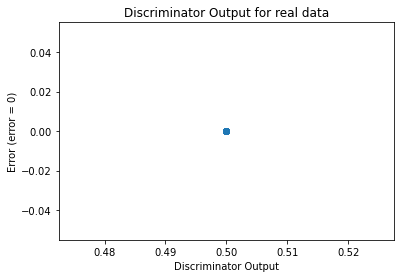

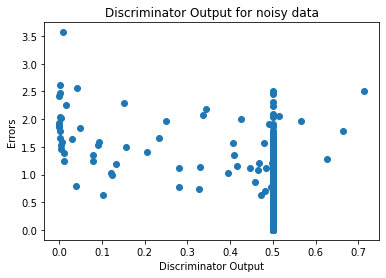

In [17]:
sanityChecks.discProbVsError(real_dataset,discriminator,device)

**Training GAN until mse of y_pred is > baseline_mse or n_epochs < 5000**

In [18]:
generator2 = network.Generator(n_features+1).to(device)
discriminator2 = network.Discriminator(n_features+1).to(device)
criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(generator2.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(discriminator2.parameters(), lr=0.01, betas=(0.5, 0.999))

In [19]:
discLossG2,genLossG2 = train_test.training_GAN_2(discriminator2,generator2,disc_opt,gen_opt,train_data,test_data,batch_size,threshold_mse,criterion,device)

Number of epochs needed 5000


In [20]:
GAN2_metrics=train_test.test_generator_2(generator2,test_data,device)

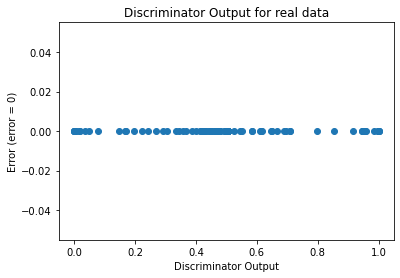

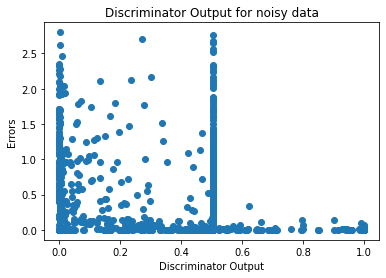

In [21]:
sanityChecks.discProbVsError(real_dataset,discriminator2,device)

# ABC GAN Model

### Training the network
**Training ABC-GAN for n_epochs number of epochs** 

In [22]:
gen = network.Generator(n_features+1).to(device)
disc = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc.parameters(), lr=0.01, betas=(0.5, 0.999))

In [23]:
discLossA1,genLossA1 = ABC_train_test.training_GAN(disc, gen,disc_opt,gen_opt,train_data,batch_size, n_epochs,criterion,coeff,mean,variance,device)

In [24]:
ABC_GAN1_metrics=ABC_train_test.test_generator(gen,test_data,coeff,mean,variance,device)

#### Sanity Checks 

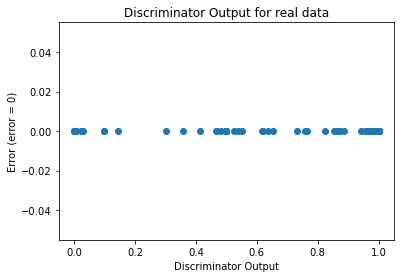

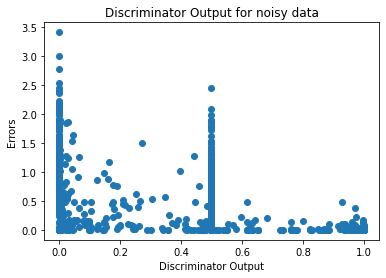

In [25]:
sanityChecks.discProbVsError(real_dataset,disc,device)

**Training ABC-GAN until mse of y_pred is > baseline_mse or n_epochs < 5000**

In [26]:
gen2 = network.Generator(n_features+1).to(device)
disc2 = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen2.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc2.parameters(), lr=0.01, betas=(0.5, 0.999))

In [27]:
discLossA2,genLossA2 = ABC_train_test.training_GAN_2(disc2,gen2,disc_opt,gen_opt,train_data,test_data,batch_size,threshold_mse,criterion,coeff,mean,variance,device)

Number of epochs 5000


In [28]:
ABC_GAN2_metrics=ABC_train_test.test_generator_2(gen2,test_data,coeff,mean,variance,device)

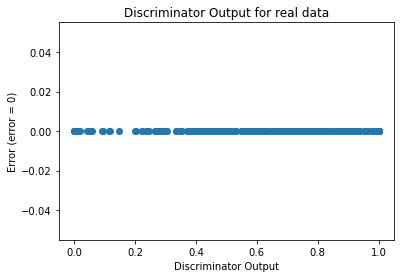

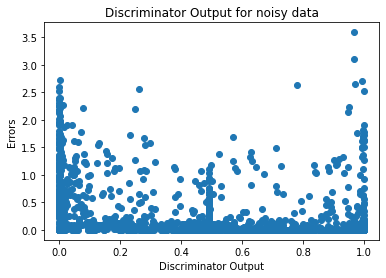

In [29]:
sanityChecks.discProbVsError(real_dataset,disc2,device)

# Model Analysis

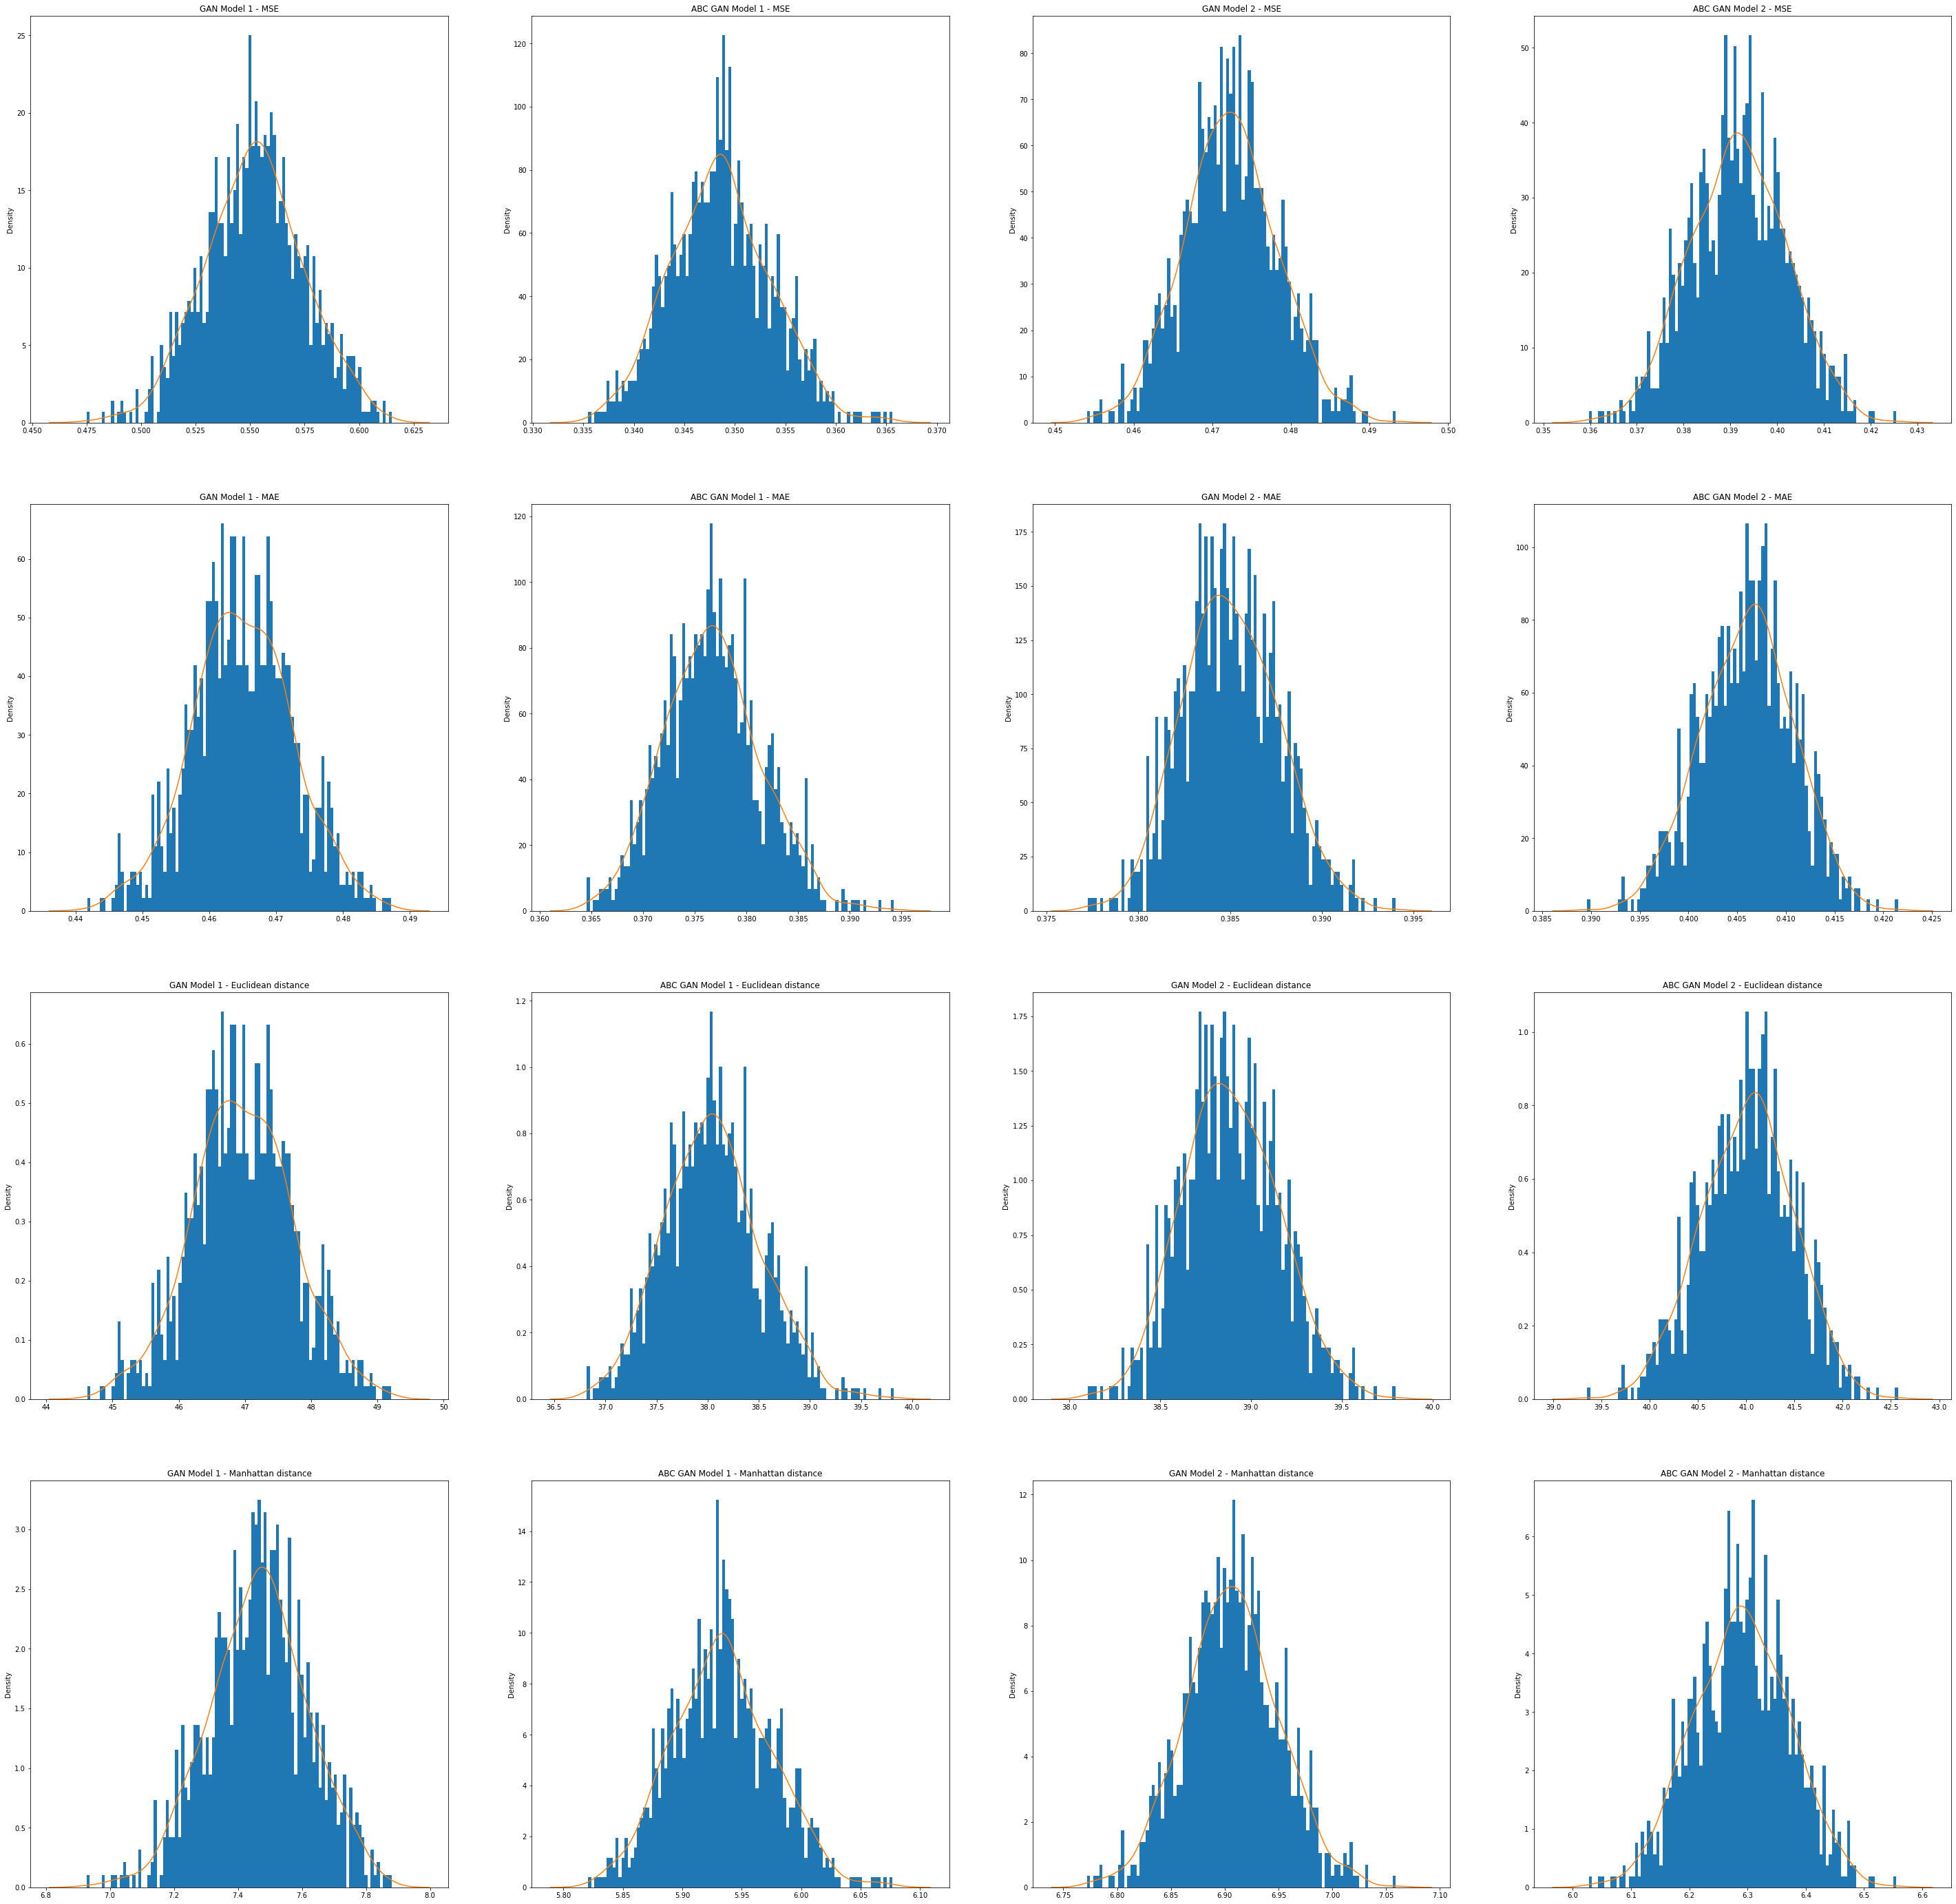

In [30]:
performanceMetrics.modelAnalysis(GAN1_metrics,ABC_GAN1_metrics,GAN2_metrics,ABC_GAN2_metrics)

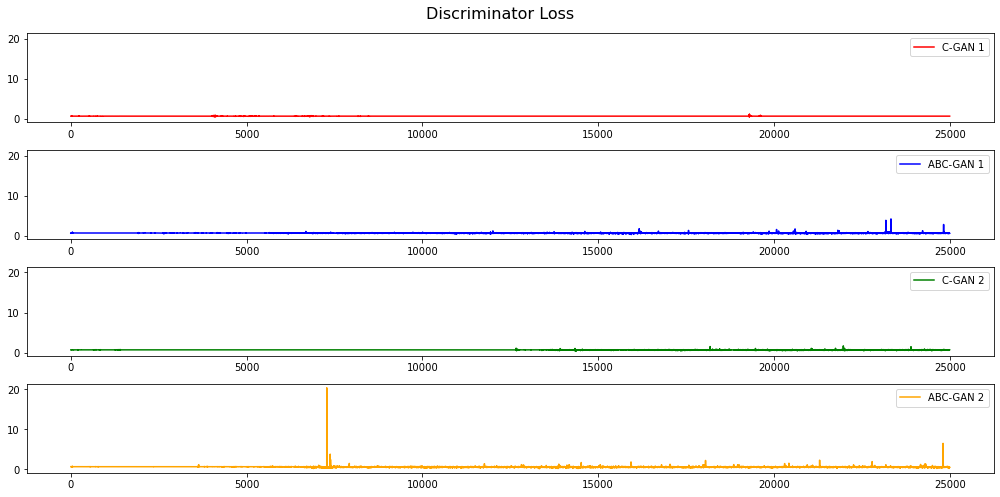

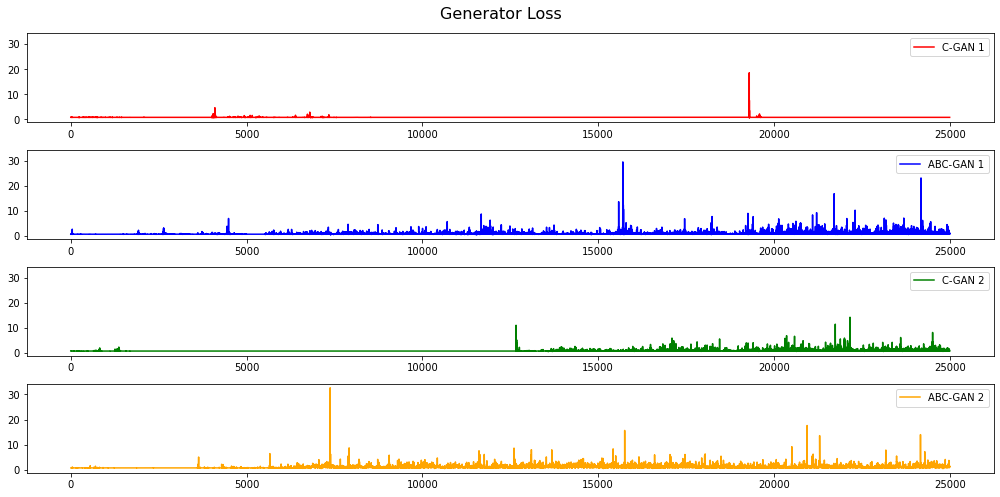

In [31]:
performanceMetrics.plotTrainingLoss(discLossG1,genLossG1,discLossA1,genLossA1,discLossG2,genLossG2,discLossA2,genLossA2)

# ABC - GAN Model with skip connection

In [32]:
gen3 = network.GeneratorWithSkipConnection(n_features+1).to(device)
disc3 = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen3.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc3.parameters(), lr=0.01, betas=(0.5, 0.999))

In [ ]:
discLossA3,genLossA3 = ABC_train_test.training_GAN(disc3, gen3,disc_opt,gen_opt,train_data,batch_size, n_epochs,criterion,coeff,mean,variance,device)

In [ ]:
ABC_GAN3_metrics=ABC_train_test.test_generator(gen3,test_data,coeff,mean,variance,device)

In [ ]:
sanityChecks.discProbVsError(real_dataset,disc3,device)

## Skip Connection Model Analysis - ABC-GAN 

### Weight Analysis 

Study the weights of the skip connection layer

Equation of the skip connection is 

$output = y_{gan} * w + y_{abc} * (1-w)$

In [ ]:
print("Weight of the node at skip connection")
for name,param in gen3.named_parameters():
    if(name == "skipNode.weight"):
        print(param)

In [ ]:
performanceMetrics.modelAnalysis2(ABC_GAN3_metrics)

In [ ]:
performanceMetrics.plotTrainingLoss2(discLossA3,genLossA3)